## 1. Deep learning model with GloVe word embeddings to represent the amenities

In [1]:
### 1. Import all the required libraries
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#### Read the cleaned data created by Michael
cleaned_data = pd.read_csv('./assets/cleaned_assets/df_cleaned.csv')

In [3]:
#### Split the cleaned data into Train, Val, Test. Splitting data before proceeding will help avoid target leakage

#### 2. Split the data into Train-Val-Test.
def get_train_val_test(df, fractions, RANDOM_SEED):
    # Get the required input and target variables from dataframe and drop NA rows:
    df = df.dropna()
    # shuffling the data:
    df = df.sample(frac = 1, random_state = RANDOM_SEED)
    # split into training, validation and testing sets
    train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))
    if len(train_df) + len(val_df) + len(test_df) != len(df):
        print("Check the splitting method!")
    else:
        return train_df, val_df, test_df

RANDOM_SEED = 44
fractions = np.array([0.6, 0.2, 0.2])
train_df, val_df, test_df = get_train_val_test(cleaned_data, fractions, RANDOM_SEED)

In [4]:
print('training size = ',len(train_df))
print('validation size = ', len(val_df))
print('test size = ', len(test_df))

training size =  43147
validation size =  14382
test size =  14383


In [5]:
def amenities_clean(string1):
    str2 = (re.sub(r'[\[\]"0-9\\u]', '',string1)).strip().lower()
    
    return str2

In [6]:
#### clean the amenities column to remove '[',']' and double quotes and covert to lower case

train_df['amenities1'] = train_df['amenities'].apply(amenities_clean)
val_df['amenities1'] = val_df['amenities'].apply(amenities_clean)
test_df['amenities1'] = test_df['amenities'].apply(amenities_clean)

In [7]:
#pip install wget

In [8]:
import wget

In [9]:
##########################################################################################################
####### This code needs to be run only once to download the pre-trained GloVe word embeddings#############
##########################################################################################################
#wget.download('http://nlp.stanford.edu/data/glove.6B.zip')

In [10]:
import zipfile
with zipfile.ZipFile("glove.6B.zip","r") as zip_ref:
    zip_ref.extractall()


In [11]:
## The archive contains 50, 100, 200 and 300 dimensional vectors. We will use the 50 dimensional vector
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
### Computing the average value of the embedding vector. Will come useful during imputations for words which are from outside the vocabulary
avg_embedding_vector = sum(embeddings_index.values())/len(embeddings_index)  

In [13]:
#### Tokenize the comments of the train data to create the Vocabulary. 
#### Please Note that tokenizer is fit only on the train_df. Word_index is a dictionary with each word of our vocabulary as the key
#### We cannot define the vocabulary using Val and Test data as it would lead to target leakage
tokenizer = Tokenizer(oov_token = '<OOV>') ### add a out of vocabulary token
tokenizer.fit_on_texts(train_df['amenities1'])
word_index = tokenizer.word_index


In [14]:
### Lets check how many words in our vocabulary do not have a word embedding vector 
no_embedding_words = []
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        no_embedding_words.append(word)

In [15]:
print('Total words in our training data vocabulary are {}'.format(len(word_index)))
print('Words not present in our pretrained embedding matrix are {}'.format(len(no_embedding_words)))

Total words in our training data vocabulary are 1590
Words not present in our pretrained embedding matrix are 393


In [16]:
### An embedding matrix consisting of the 50-D embedding vector for each word in our training dataset 
### for words which don't have the embedding vector, we impute with the avg embedding vector
embedding_matrix = np.zeros((len(word_index)+1,50))  ##Nishant: Update with Dimensions
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = avg_embedding_vector
    embedding_matrix[i] = embedding_vector

In [17]:
#### This is the tricky part!! 
#### Each listing has a varied number of amenities (e.g. "Dryer", "TV with standard cable", "Long term stays allowed", "Kitchen", "Wifi", "Washer", "Heating" ).
#### Note that some of the amenities are words and some are phrases. Now GloVe vectorizes one word at a time
#### Our strategy is to find average vector for each amenity and then average across all amenities 

def avg_embedding(all_amenities):
    list_amenities = [i.strip() for i in all_amenities.split(",")] ###get the list of amenities
    list_seq = tokenizer.texts_to_sequences(list_amenities)
    arr_all_amenity = np.zeros(50)
    for j in list_seq:
        arr1 = np.zeros(50)
        for k in j:
            arr1 = arr1+embedding_matrix[k]
        avg_arr1 = arr1/max(1,len(j)) #### avg embedding vector for each amenity
        arr_all_amenity = arr_all_amenity+avg_arr1
    arr_final = arr_all_amenity/max(1,len(list_seq))
    return arr_final



In [18]:
#### Identify the columns to be standardized.
cols = ['total_crimes','Population per square kilometre','Property price','accommodates','minimum_nights','maximum_nights','number_of_reviews','amenities_count',\
        'closest_station_dist','within_1k_station','closest_POI_dist','within_5k_POI','dist_from_center']

scaler = StandardScaler()
train_df[cols] = scaler.fit_transform(train_df[cols])
val_df[cols] = scaler.transform(val_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

In [19]:
#### Create dummy variables (one-hot encoding) for Borough, room_type, property_type. Lets not create dummies
train_df1 = pd.get_dummies(train_df, columns = ['Borough','room_type','property_type'])
val_df1 = pd.get_dummies(val_df, columns = ['Borough','room_type','property_type'])
test_df1 = pd.get_dummies(test_df, columns = ['Borough','room_type','property_type'])

In [20]:
train_df1, val_df1 = train_df1.align(val_df1, join='left', axis=1, fill_value = 0)
train_df1, test_df1 = train_df1.align(test_df1, join='left', axis=1, fill_value = 0)

In [21]:
#### look at the quantile for price
train_df.price.quantile([0.01,0.02,0.95,0.98,0.99])

0.01      20.00
0.02      24.00
0.95     495.00
0.98    1047.24
0.99    1570.00
Name: price, dtype: float64

In [22]:
#### Get the variables from the CNN model by Elias
attract_data = pd.read_csv('./assets/cleaned_assets/id_score.csv')

print(attract_data.head())

   image_id  interior    entire       avg  normalized_avg
0     13913  5.221664  5.358303  5.289983        6.426101
1     15400  5.099636  5.424931  5.262284        6.300351
2    172811  4.972842  3.823302  4.398072        2.377051
3    173082  5.765924  5.875356  5.820640        8.835144
4     42010  5.487355  5.249705  5.368530        6.782684


In [23]:
### merge the CNN model data to the train_df1, val_df1, test_df1
train_df2 = pd.merge(left = train_df1, right = attract_data, left_on = 'id', right_on = 'image_id', how = 'inner')

val_df2 = pd.merge(left = val_df1, right = attract_data, left_on = 'id', right_on = 'image_id', how = 'inner')

test_df2 = pd.merge(left = test_df1, right = attract_data, left_on = 'id', right_on = 'image_id', how = 'inner')

In [24]:
####updated counts

print('New train data', train_df2.shape)
print('New val data', val_df2.shape)
print('New test data', test_df2.shape)

New train data (30725, 158)
New val data (10178, 158)
New test data (10172, 158)


#### 1A: Deep leaning model with GloVe embedding + features from the CNN model 

In [25]:
#### Run the model using all features including the ones created by CNN
def final_df_with_cnn(input_df):
    input_df['price1'] = np.where(input_df.price > 1570, 1570, input_df.price) ###Cap the price to handle extreme values
    input_df['price1'] = np.where(input_df.price1 < 20, 20, input_df.price1) ###Floor price to handle extreme values
    all_amenities = input_df['amenities1']
    other_features = input_df.drop(columns = ['Unnamed: 0', 'Census population', 'id','neighbourhood_cleansed','latitude', 'longitude','host_since',\
              'amenities','amenities1','price','price1','image_id','avg',\
               'host_identity_verified','host_is_superhost','host_has_profile_pic']) ##keeping normalized avg

    dv1 = np.log(input_df['price1'])

    idv1 = other_features.to_numpy()
    dv_f = dv1.to_numpy()
    #### Now lets convert the amenities to BERT embeddings
    amenities_array = np.zeros((len(input_df),50))
    cnt = 0
    for i in all_amenities:
        amenities_array[cnt] = avg_embedding(i)
        cnt = cnt +1
    x_final = np.concatenate((idv1,amenities_array), axis = 1)
    return x_final, dv_f

In [26]:
X_train, y_train = final_df_with_cnn(train_df2)
X_val, y_val = final_df_with_cnn(val_df2)
X_test, y_test = final_df_with_cnn(test_df2)

In [27]:
X_test.shape

(10172, 193)

In [28]:
model = Sequential([
    Dense(256, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(32, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(16, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(1, activation = 'linear', kernel_regularizer = tf.keras.regularizers.L2(0.001))
])

In [29]:
model.compile(optimizer = 'adam',
            loss = 'mse',
             metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [30]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_data = (X_val, y_val))

Epoch 1/50
481/481 [==============================] - 2s 2ms/step - loss: 0.8307 - root_mean_squared_error: 0.7524 - val_loss: 0.5113 - val_root_mean_squared_error: 0.5665
Epoch 2/50
481/481 [==============================] - 1s 2ms/step - loss: 0.4759 - root_mean_squared_error: 0.5586 - val_loss: 0.4464 - val_root_mean_squared_error: 0.5507
Epoch 3/50
481/481 [==============================] - 1s 2ms/step - loss: 0.4278 - root_mean_squared_error: 0.5468 - val_loss: 0.4085 - val_root_mean_squared_error: 0.5409
Epoch 4/50
481/481 [==============================] - 1s 2ms/step - loss: 0.3890 - root_mean_squared_error: 0.5312 - val_loss: 0.3768 - val_root_mean_squared_error: 0.5276
Epoch 5/50
481/481 [==============================] - 1s 2ms/step - loss: 0.3645 - root_mean_squared_error: 0.5215 - val_loss: 0.3546 - val_root_mean_squared_error: 0.5184
Epoch 6/50
481/481 [==============================] - 1s 2ms/step - loss: 0.3351 - root_mean_squared_error: 0.5041 - val_loss: 0.3316 - val_

In [33]:
### Predicted value

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [32]:
from sklearn.metrics import r2_score

In [34]:
print('The train R-squared is', round(r2_score(y_train, y_pred_train),6))
print('The val R-squared is', round(r2_score(y_val, y_pred_val),6))
print('The test R-squared is', round(r2_score(y_test, y_pred_test),6))



The train R-squared is 0.715893
The val R-squared is 0.682371
The test R-squared is 0.691432


In [35]:
#### Checking the loss and rmse on the Test data
loss, rmse = model.evaluate(X_test, y_test)

print('loss on test is:', loss)
print('rmse on test is:', rmse)

318/318 [==============================] - 0s 1ms/step - loss: 0.2442 - root_mean_squared_error: 0.4655
loss on test is: 0.24419081211090088
rmse on test is: 0.4655216336250305


In [36]:
df = pd.DataFrame(history.history)
display(df.head())

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.830655,0.752445,0.511330,0.566493
1,0.475860,0.558557,0.446414,0.550726
2,0.427826,0.546770,0.408540,0.540877
3,0.388959,0.531166,0.376836,0.527588
4,0.364492,0.521504,0.354588,0.518356


In [37]:
df['epochs'] = df.index + 1
df['epochs'] = df['epochs'].apply(str)
display(df.head())

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epochs
0,0.830655,0.752445,0.511330,0.566493,1
1,0.475860,0.558557,0.446414,0.550726,2
2,0.427826,0.546770,0.408540,0.540877,3
3,0.388959,0.531166,0.376836,0.527588,4
4,0.364492,0.521504,0.354588,0.518356,5


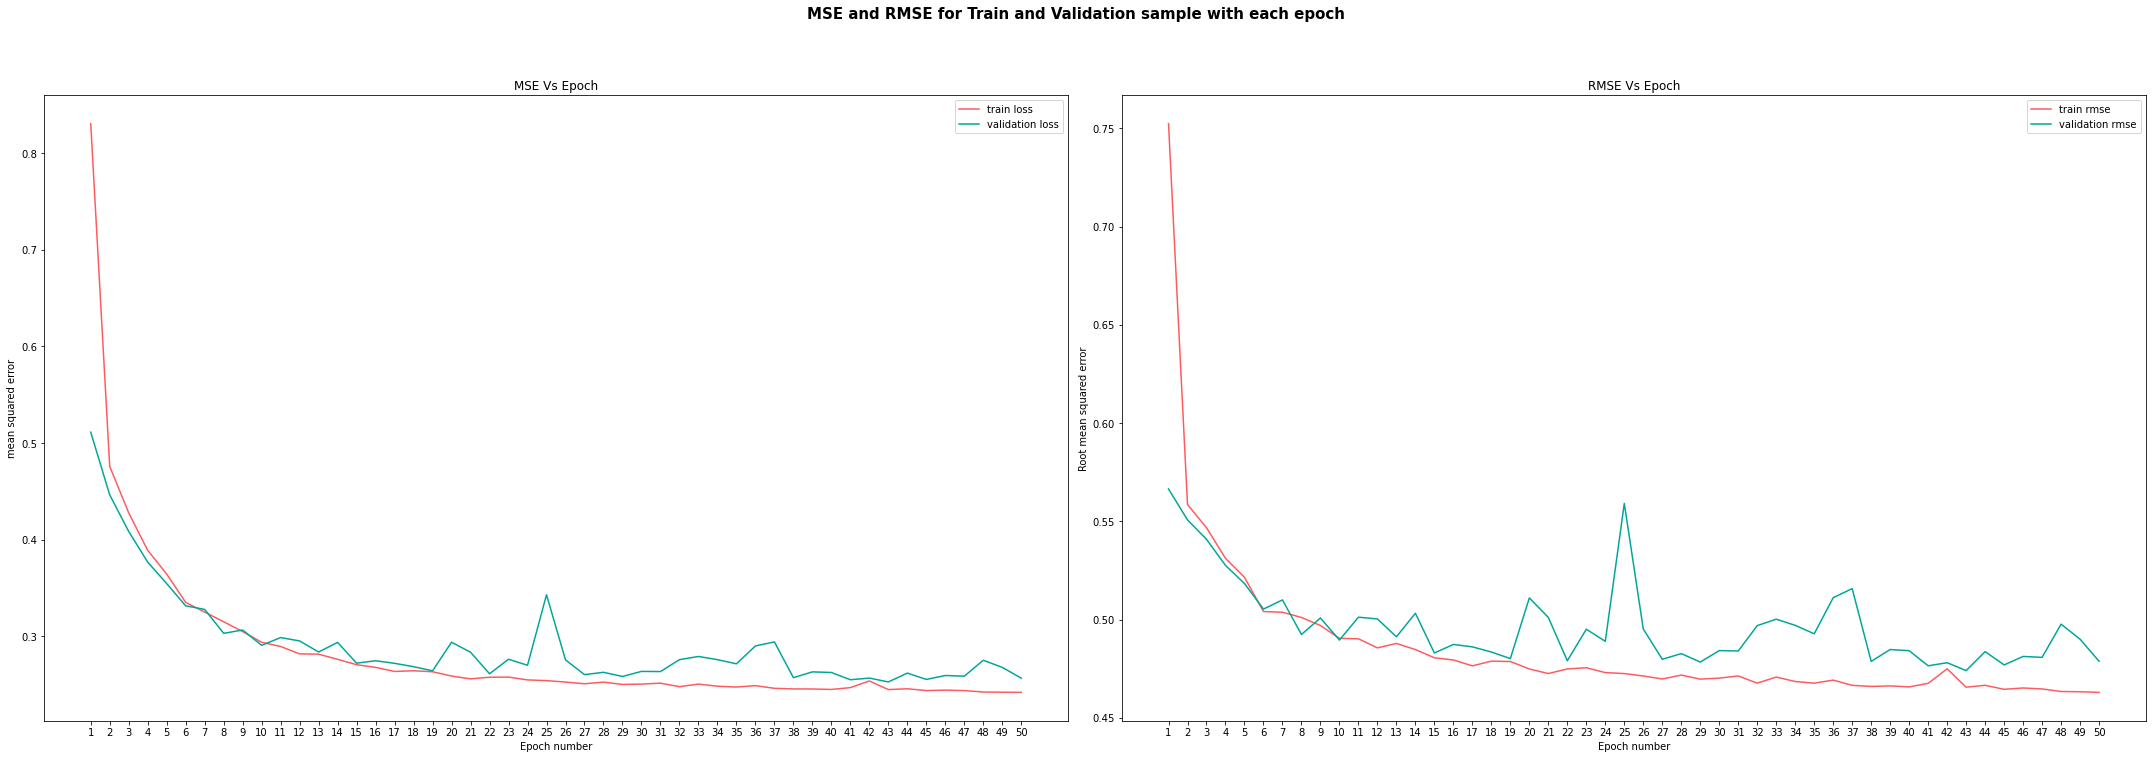

In [38]:
### Plot the graphs
fig, ax = plt.subplots(1,2, figsize = (30,10))
ax[0].plot(df['epochs'], df['loss'], color = '#FF5A5F')
ax[0].plot(df['epochs'], df['val_loss'], color = '#00A699')
ax[0].legend(['train loss', 'validation loss'])
ax[0].set(xlabel="Epoch number", ylabel="mean squared error")
ax[0].set_title('MSE Vs Epoch')

ax[1].plot(df['epochs'],df['root_mean_squared_error'],color = '#FF5A5F')
ax[1].plot(df['epochs'], df['val_root_mean_squared_error'],color = '#00A699')
ax[1].legend(['train rmse', 'validation rmse'])
ax[1].set(xlabel="Epoch number", ylabel="Root mean squared error")
ax[1].set_title('RMSE Vs Epoch')

fig.suptitle('MSE and RMSE for Train and Validation sample with each epoch', fontsize = 15, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.show()

#### 1B: Deep leaning model with GloVe embedding (Not including features from the CNN model )

In [39]:
#### Run the model using all features except the ones created by CNN
def final_df_without_cnn(input_df):
    input_df['price1'] = np.where(input_df.price > 1570, 1570, input_df.price) ###Cap the price to handle extreme values
    input_df['price1'] = np.where(input_df.price1 < 20, 20, input_df.price1) ###Floor the price to handle extreme values
    all_amenities = input_df['amenities1']
    other_features = input_df.drop(columns = ['Unnamed: 0', 'Census population', 'id','neighbourhood_cleansed','latitude', 'longitude','host_since',\
              'amenities','amenities1','price','price1','image_id','avg',\
               'host_identity_verified','host_is_superhost','host_has_profile_pic', 'normalized_avg', 'interior', 'entire']) ##keeping normalized avg

    dv1 = np.log(input_df['price1'])

    idv1 = other_features.to_numpy()
    dv_f = dv1.to_numpy()
    #### Now lets convert the amenities to BERT embeddings
    amenities_array = np.zeros((len(input_df),50))
    cnt = 0
    for i in all_amenities:
        amenities_array[cnt] = avg_embedding(i)
        cnt = cnt +1
    x_final = np.concatenate((idv1,amenities_array), axis = 1)
    return x_final, dv_f

In [40]:
X_train, y_train = final_df_without_cnn(train_df2)
X_val, y_val = final_df_without_cnn(val_df2)
X_test, y_test = final_df_without_cnn(test_df2)

In [41]:
X_test.shape

(10172, 190)

In [42]:
model = Sequential([
    Dense(256, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(32, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(16, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)),
    Dense(1, activation = 'linear', kernel_regularizer = tf.keras.regularizers.L2(0.001))
])

In [43]:
model.compile(optimizer = 'adam',
            loss = 'mse',
             metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [44]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_data = (X_val, y_val))

Epoch 1/50
481/481 [==============================] - 2s 2ms/step - loss: 1.1765 - root_mean_squared_error: 0.9110 - val_loss: 0.5720 - val_root_mean_squared_error: 0.5578
Epoch 2/50
481/481 [==============================] - 1s 2ms/step - loss: 0.5334 - root_mean_squared_error: 0.5588 - val_loss: 0.4925 - val_root_mean_squared_error: 0.5511
Epoch 3/50
481/481 [==============================] - 1s 2ms/step - loss: 0.4564 - root_mean_squared_error: 0.5378 - val_loss: 0.4229 - val_root_mean_squared_error: 0.5237
Epoch 4/50
481/481 [==============================] - 1s 2ms/step - loss: 0.4123 - root_mean_squared_error: 0.5263 - val_loss: 0.4243 - val_root_mean_squared_error: 0.5487
Epoch 5/50
481/481 [==============================] - 1s 2ms/step - loss: 0.3775 - root_mean_squared_error: 0.5133 - val_loss: 0.3606 - val_root_mean_squared_error: 0.5052
Epoch 6/50
481/481 [==============================] - 1s 2ms/step - loss: 0.3561 - root_mean_squared_error: 0.5076 - val_loss: 0.3425 - val_

In [46]:
### Predicted value

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [47]:
from sklearn.metrics import r2_score

print('The train R-squared is', round(r2_score(y_train, y_pred_train),6))
print('The val R-squared is', round(r2_score(y_val, y_pred_val),6))
print('The test R-squared is', round(r2_score(y_test, y_pred_test),6))

The train R-squared is 0.701787
The val R-squared is 0.663985
The test R-squared is 0.672094


In [48]:
#### Checking the loss and rmse on the Test data
loss, rmse = model.evaluate(X_test, y_test)

print('loss on test is:', loss)
print('rmse on test is:', rmse)

318/318 [==============================] - 0s 1ms/step - loss: 0.2600 - root_mean_squared_error: 0.4799
loss on test is: 0.2600051760673523
rmse on test is: 0.4798874258995056


In [49]:
df = pd.DataFrame(history.history)


df['epochs'] = df.index + 1
df['epochs'] = df['epochs'].apply(str)
display(df)

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epochs
0,1.176540,0.911049,0.572024,0.557805,1
1,0.533373,0.558761,0.492502,0.551104,2
2,0.456394,0.537798,0.422876,0.523741,3
3,0.412345,0.526267,0.424298,0.548730,4
4,0.377540,0.513255,0.360647,0.505218,5
5,0.356147,0.507617,0.342537,0.500802,6
6,0.337177,0.501019,0.346328,0.515605,7
7,0.323354,0.496859,0.317677,0.495171,8
8,0.312422,0.493653,0.320083,0.505649,9
9,0.303630,0.491828,0.300533,0.491486,10


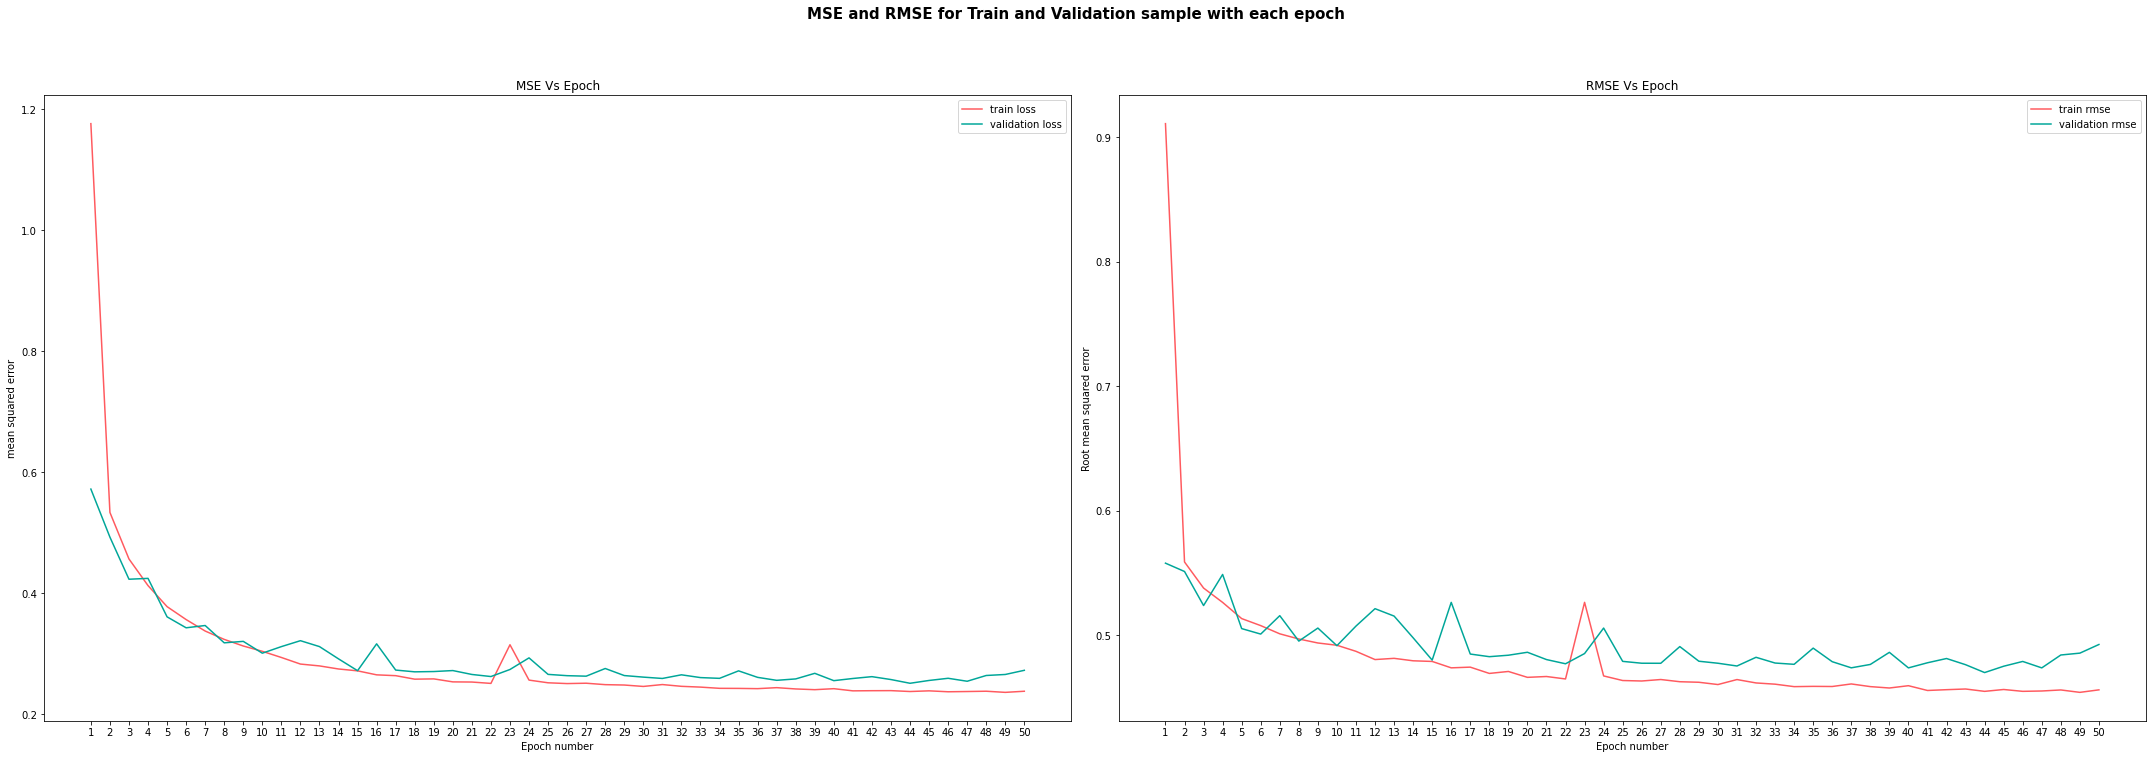

In [50]:
### Plot the graphs
fig, ax = plt.subplots(1,2, figsize = (30,10))
ax[0].plot(df['epochs'], df['loss'], color = '#FF5A5F')
ax[0].plot(df['epochs'], df['val_loss'], color = '#00A699')
ax[0].legend(['train loss', 'validation loss'])
ax[0].set(xlabel="Epoch number", ylabel="mean squared error")
ax[0].set_title('MSE Vs Epoch')

ax[1].plot(df['epochs'],df['root_mean_squared_error'],color = '#FF5A5F')
ax[1].plot(df['epochs'], df['val_root_mean_squared_error'],color = '#00A699')
ax[1].legend(['train rmse', 'validation rmse'])
ax[1].set(xlabel="Epoch number", ylabel="Root mean squared error")
ax[1].set_title('RMSE Vs Epoch')

fig.suptitle('MSE and RMSE for Train and Validation sample with each epoch', fontsize = 15, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.show()

## 2. Deep learning model with BERT embeddings to represent the amenities

In [86]:

#pip install --quiet "tensorflow-text==2.8.*"

In [51]:
### Import all the required libraries
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# Define the model
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2"
 
# Choose the preprocessing that must match the model
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [53]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

In [54]:
def text_to_emb(input_text):
    input_text_lst = [input_text]
    inputs = preprocess(input_text_lst)
    outputs = bert(inputs)
    return np.array((outputs['pooled_output']))


In [55]:
cleaned_data = pd.read_csv('./assets/cleaned_assets/df_cleaned.csv')

In [56]:
#### Split the cleaned data into Train, Val, Test. Splitting data before proceeding will help avoid target leakage

#### 2. Split the data into Train-Val-Test.
def get_train_val_test(df, fractions, RANDOM_SEED):
    # Get the required input and target variables from dataframe and drop NA rows:
    df = df.dropna()
    # shuffling the data:
    df = df.sample(frac = 1, random_state = RANDOM_SEED)
    # split into training, validation and testing sets
    train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))
    
    if len(train_df) + len(val_df) + len(test_df) != len(df):
        print("Check the splitting method!")
    else:
        return train_df, val_df, test_df

RANDOM_SEED = 44
fractions = np.array([0.6, 0.2, 0.2])
train_df, val_df, test_df = get_train_val_test(cleaned_data, fractions, RANDOM_SEED)

In [57]:
print('training size = ',len(train_df))
print('validation size = ', len(val_df))
print('test size = ', len(test_df))

training size =  43147
validation size =  14382
test size =  14383


In [58]:
def amenities_clean(string1):
    str2 = (re.sub(r'[\[\]"0-9\\u]', '',string1)).strip().lower()
    
    return str2

In [59]:
#### clean the amenities column to remove '[',']' and double quotes and covert to lower case

train_df['amenities1'] = train_df['amenities'].apply(amenities_clean)
val_df['amenities1'] = val_df['amenities'].apply(amenities_clean)
test_df['amenities1'] = test_df['amenities'].apply(amenities_clean)


In [ ]:
#################################################################################
#####IMPORTANT : RUN THIS ONLY ONCE. ITS TAKES A LOT OF TIME TO RUN##############
#################################################################################

#### get the BERT embedding for each unique phrase in the training data
train_all_amenities = train_df2['amenities1']
all_phrases = set()

for i in train_all_amenities:
    list_amenities = [k.strip() for k in i.split(",")]
    for j in list_amenities:
        all_phrases.add(j)
all_phrases.remove('') ###removing blank phrases

embedding_dict = {}
for amm1 in list(all_phrases):
    embedding_dict[amm1] = text_to_emb(amm1).flatten()
    


In [63]:
####this will come useful if we are not able to 
avg_embedding = np.mean(list(embedding_dict.values()), axis = 0)
avg_embedding.shape

(768,)

In [ ]:
### writing the dictionary somewhere because it takes a long time to run
import pickle

with open('bert_data.pkl', 'wb') as fp:
    pickle.dump(embedding_dict, fp)
    print('dictionary saved successfully to file')

In [60]:
import pickle
#### load the bert pickle file
with open('bert_data.pkl', 'rb') as fp:
    embedding_dict_copy = pickle.load(fp)
    print('bert dictionary')
    


bert dictionary


In [62]:
###Uncomment when you need to use the saved embedding dictionary
#embedding_dict = embedding_dict_copy

In [64]:
def bert_avg_embedding(all_amenities):
    list_amenities = [i.strip() for i in all_amenities.split(",")]
    arr1 = np.zeros(768)
    for each_a in list_amenities:
        try:
            ret_arr = embedding_dict[each_a]
        except:
            ret_arr = avg_embedding
        arr1 = arr1+ret_arr
    avg_array = arr1/max(1,len(list_amenities))
    return avg_array

In [65]:
#### Identify the columns to be standardized.
cols = ['total_crimes','Population per square kilometre','Property price','accommodates','minimum_nights','maximum_nights','number_of_reviews','amenities_count',\
        'closest_station_dist','within_1k_station','closest_POI_dist','within_5k_POI','dist_from_center']

scaler = StandardScaler()
train_df[cols] = scaler.fit_transform(train_df[cols])
val_df[cols] = scaler.transform(val_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

In [66]:
#### Create dummy variables (one-hot encoding) for Borough, room_type, property_type. Lets not create dummies
train_df1 = pd.get_dummies(train_df, columns = ['Borough','room_type','property_type'])
val_df1 = pd.get_dummies(val_df, columns = ['Borough','room_type','property_type'])
test_df1 = pd.get_dummies(test_df, columns = ['Borough','room_type','property_type'])

In [67]:
train_df1, val_df1 = train_df1.align(val_df1, join='left', axis=1, fill_value = 0)

train_df1, test_df1 = train_df1.align(test_df1, join='left', axis=1, fill_value = 0)

In [68]:
val_df1.shape

(14382, 153)

In [69]:
#### look at the quantile for price
train_df.price.quantile([0.01,0.02,0.95,0.98,0.99])

0.01      20.00
0.02      24.00
0.95     495.00
0.98    1047.24
0.99    1570.00
Name: price, dtype: float64

In [70]:
#### Get the variables from the CNN model by Elias
attract_data = pd.read_csv('./assets/cleaned_assets/id_score.csv')

print(attract_data.head())

   image_id  interior    entire       avg  normalized_avg
0     13913  5.221664  5.358303  5.289983        6.426101
1     15400  5.099636  5.424931  5.262284        6.300351
2    172811  4.972842  3.823302  4.398072        2.377051
3    173082  5.765924  5.875356  5.820640        8.835144
4     42010  5.487355  5.249705  5.368530        6.782684


In [71]:
### merge the CNN model data to the train_df1, val_df1, test_df1
train_df2 = pd.merge(left = train_df1, right = attract_data, left_on = 'id', right_on = 'image_id', how = 'inner')

val_df2 = pd.merge(left = val_df1, right = attract_data, left_on = 'id', right_on = 'image_id', how = 'inner')

test_df2 = pd.merge(left = test_df1, right = attract_data, left_on = 'id', right_on = 'image_id', how = 'inner')

In [72]:
####updated counts

print('New train data', train_df2.shape)
print('New val data', val_df2.shape)
print('New test data', test_df2.shape)

New train data (30725, 158)
New val data (10178, 158)
New test data (10172, 158)


#### 2A: Deep leaning model with BERT embedding + features from the CNN model 

In [87]:
#### Run the model using all features including the ones created by CNN
def final_df_BERT_with_CNN(input_df):
    input_df['price1'] = np.where(input_df.price > 1570, 1570, input_df.price) ###Cap the price to handle extreme values
    input_df['price1'] = np.where(input_df.price1 < 20, 20, input_df.price1) ###Floor the price to handle extreme values
    all_amenities = input_df['amenities1']
    other_features = input_df.drop(columns = ['Unnamed: 0', 'Census population', 'id','neighbourhood_cleansed','latitude', 'longitude','host_since',\
              'amenities','amenities1','price','price1','image_id','avg',\
               'host_identity_verified','host_is_superhost','host_has_profile_pic']) ##keeping normalized avg

    dv1 = np.log(input_df['price1'])

    idv1 = other_features.to_numpy()
    dv_f = dv1.to_numpy()
    #### Now lets convert the amenities to BERT embeddings
    amenities_array = np.zeros((len(input_df),768))
    cnt = 0
    for i in all_amenities:
        amenities_array[cnt] = bert_avg_embedding(i)
        cnt = cnt +1
    x_final = np.concatenate((idv1,amenities_array), axis = 1)
    return x_final, dv_f

In [88]:
X_train, y_train = final_df_BERT_with_CNN(train_df2)

X_val, y_val = final_df_BERT_with_CNN(val_df2)


X_test, y_test = final_df_BERT_with_CNN(test_df2)

In [89]:
X_test.shape

(10172, 911)

In [95]:
model = Sequential([
    Dense(256, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(32, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(16, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(1, activation = 'linear', kernel_regularizer = tf.keras.regularizers.L2(0.0001))
])

In [96]:
model.compile(optimizer = 'adam',
            loss = 'mse',
             metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [97]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_val, y_val))

Epoch 1/100
481/481 [==============================] - 2s 3ms/step - loss: 0.5774 - root_mean_squared_error: 0.7306 - val_loss: 0.3430 - val_root_mean_squared_error: 0.5506
Epoch 2/100
481/481 [==============================] - 1s 3ms/step - loss: 0.3561 - root_mean_squared_error: 0.5640 - val_loss: 0.3326 - val_root_mean_squared_error: 0.5439
Epoch 3/100
481/481 [==============================] - 1s 3ms/step - loss: 0.3502 - root_mean_squared_error: 0.5608 - val_loss: 0.3255 - val_root_mean_squared_error: 0.5390
Epoch 4/100
481/481 [==============================] - 1s 3ms/step - loss: 0.3246 - root_mean_squared_error: 0.5390 - val_loss: 0.2956 - val_root_mean_squared_error: 0.5121
Epoch 5/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2997 - root_mean_squared_error: 0.5167 - val_loss: 0.2908 - val_root_mean_squared_error: 0.5087
Epoch 6/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2811 - root_mean_squared_error: 0.5001 - val_loss: 0.3245 

481/481 [==============================] - 1s 3ms/step - loss: 0.2201 - root_mean_squared_error: 0.4535 - val_loss: 0.2902 - val_root_mean_squared_error: 0.5252
Epoch 96/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2199 - root_mean_squared_error: 0.4534 - val_loss: 0.2437 - val_root_mean_squared_error: 0.4790
Epoch 97/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2203 - root_mean_squared_error: 0.4539 - val_loss: 0.2632 - val_root_mean_squared_error: 0.4989
Epoch 98/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2206 - root_mean_squared_error: 0.4542 - val_loss: 0.3395 - val_root_mean_squared_error: 0.5702
Epoch 99/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2502 - root_mean_squared_error: 0.4853 - val_loss: 0.2522 - val_root_mean_squared_error: 0.4873
Epoch 100/100
481/481 [==============================] - 1s 3ms/step - loss: 0.2231 - root_mean_squared_error: 0.4566 - val_loss: 0.2339 - val_

In [98]:
### Predicted value

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [99]:
from sklearn.metrics import r2_score

print('The train R-squared is', round(r2_score(y_train, y_pred_train),6))
print('The val R-squared is', round(r2_score(y_val, y_pred_val),6))
print('The test R-squared is', round(r2_score(y_test, y_pred_test),6))

The train R-squared is 0.73143
The val R-squared is 0.696051
The test R-squared is 0.705863


In [100]:
#### Checking the loss and rmse on the Test data
loss, rmse = model.evaluate(X_test, y_test)

print('loss on test is:', loss)
print('rmse on test is:', rmse)

318/318 [==============================] - 0s 1ms/step - loss: 0.2211 - root_mean_squared_error: 0.4545
loss on test is: 0.22108541429042816
rmse on test is: 0.454505980014801


In [101]:
df = pd.DataFrame(history.history)


df['epochs'] = df.index + 1
df['epochs'] = df['epochs'].apply(str)
display(df.head())

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epochs
0,0.577420,0.730576,0.343026,0.550615,1
1,0.356066,0.563951,0.332599,0.543862,2
2,0.350233,0.560759,0.325470,0.538976,3
3,0.324648,0.538993,0.295601,0.512091,4
4,0.299673,0.516651,0.290799,0.508743,5


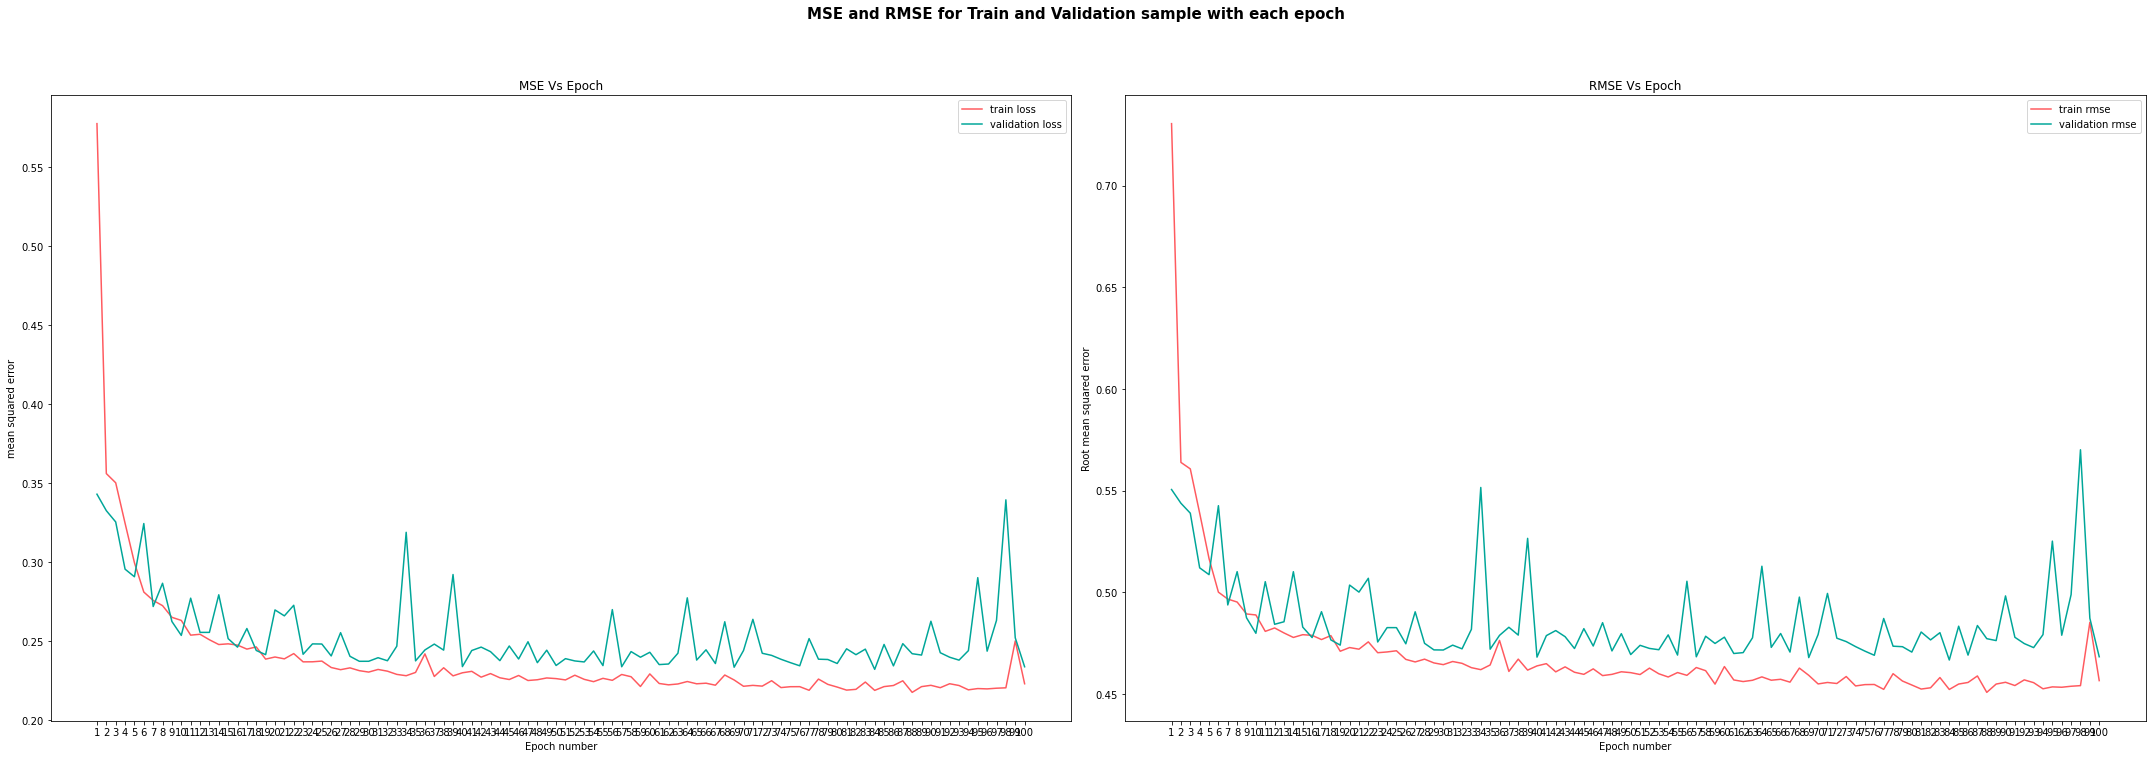

In [102]:
### Plot the graphs
fig, ax = plt.subplots(1,2, figsize = (30,10))
ax[0].plot(df['epochs'], df['loss'], color = '#FF5A5F')
ax[0].plot(df['epochs'], df['val_loss'], color = '#00A699')
ax[0].legend(['train loss', 'validation loss'])
ax[0].set(xlabel="Epoch number", ylabel="mean squared error")
ax[0].set_title('MSE Vs Epoch')

ax[1].plot(df['epochs'],df['root_mean_squared_error'],color = '#FF5A5F')
ax[1].plot(df['epochs'], df['val_root_mean_squared_error'],color = '#00A699')
ax[1].legend(['train rmse', 'validation rmse'])
ax[1].set(xlabel="Epoch number", ylabel="Root mean squared error")
ax[1].set_title('RMSE Vs Epoch')

fig.suptitle('MSE and RMSE for Train and Validation sample with each epoch', fontsize = 15, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.show()

#### 2B: Deep leaning model with BERT embedding (Excluding features from CNN model)

In [103]:
#### Run the model using all features including the ones created by CNN
def final_df_BERT_without_CNN(input_df):
    input_df['price1'] = np.where(input_df.price > 1570, 1570, input_df.price) ###Cap the price to handle extreme values
    input_df['price1'] = np.where(input_df.price1 < 20, 20, input_df.price1)  ###Floor the price to handle extreme values
    all_amenities = input_df['amenities1']
    other_features = input_df.drop(columns = ['Unnamed: 0', 'Census population', 'id','neighbourhood_cleansed','latitude', 'longitude','host_since',\
              'amenities','amenities1','price','price1','image_id','avg',\
               'host_identity_verified','host_is_superhost','host_has_profile_pic','normalized_avg', 'interior', 'entire']) ##keeping normalized avg

    dv1 = np.log(input_df['price1'])

    idv1 = other_features.to_numpy()
    dv_f = dv1.to_numpy()
    #### Now lets convert the amenities to BERT embeddings
    amenities_array = np.zeros((len(input_df),768))
    cnt = 0
    for i in all_amenities:
        amenities_array[cnt] = bert_avg_embedding(i)
        cnt = cnt +1
    x_final = np.concatenate((idv1,amenities_array), axis = 1)
    return x_final, dv_f

In [104]:
X_train, y_train = final_df_BERT_without_CNN(train_df2)

X_val, y_val = final_df_BERT_without_CNN(val_df2)


X_test, y_test = final_df_BERT_without_CNN(test_df2)

In [105]:
X_test.shape

(10172, 908)

In [114]:
model = Sequential([
    Dense(128, activation = 'relu', input_shape = (X_train.shape[1],), kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(32, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(16, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    Dense(1, activation = 'linear', kernel_regularizer = tf.keras.regularizers.L2(0.0001))
])

In [115]:
model.compile(optimizer = 'adam',
            loss = 'mse',
             metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [116]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_val, y_val))

Epoch 1/100
481/481 [==============================] - 2s 2ms/step - loss: 0.6465 - root_mean_squared_error: 0.7858 - val_loss: 0.3369 - val_root_mean_squared_error: 0.5571
Epoch 2/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3432 - root_mean_squared_error: 0.5637 - val_loss: 0.3368 - val_root_mean_squared_error: 0.5588
Epoch 3/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3358 - root_mean_squared_error: 0.5585 - val_loss: 0.3310 - val_root_mean_squared_error: 0.5547
Epoch 4/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3085 - root_mean_squared_error: 0.5343 - val_loss: 0.2982 - val_root_mean_squared_error: 0.5249
Epoch 5/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2891 - root_mean_squared_error: 0.5164 - val_loss: 0.3684 - val_root_mean_squared_error: 0.5883
Epoch 6/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2759 - root_mean_squared_error: 0.5040 - val_loss: 0.2629 

481/481 [==============================] - 1s 2ms/step - loss: 0.2187 - root_mean_squared_error: 0.4531 - val_loss: 0.2422 - val_root_mean_squared_error: 0.4785
Epoch 96/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4532 - val_loss: 0.2326 - val_root_mean_squared_error: 0.4682
Epoch 97/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4540 - val_loss: 0.2398 - val_root_mean_squared_error: 0.4758
Epoch 98/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4503 - val_loss: 0.2434 - val_root_mean_squared_error: 0.4797
Epoch 99/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2197 - root_mean_squared_error: 0.4543 - val_loss: 0.2310 - val_root_mean_squared_error: 0.4665
Epoch 100/100
481/481 [==============================] - 1s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4521 - val_loss: 0.2512 - val_

In [117]:
### Predicted value

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [118]:
from sklearn.metrics import r2_score

print('The train R-squared is', round(r2_score(y_train, y_pred_train),6))
print('The val R-squared is', round(r2_score(y_val, y_pred_val),6))
print('The test R-squared is', round(r2_score(y_test, y_pred_test),6))

The train R-squared is 0.705053
The val R-squared is 0.670578
The test R-squared is 0.681306


In [119]:
#### Checking the loss and rmse on the Test data
loss, rmse = model.evaluate(X_test, y_test)

print('loss on test is:', loss)
print('rmse on test is:', rmse)

318/318 [==============================] - 0s 995us/step - loss: 0.2372 - root_mean_squared_error: 0.4731
loss on test is: 0.23724360764026642
rmse on test is: 0.47309842705726624


In [121]:
df = pd.DataFrame(history.history)


df['epochs'] = df.index + 1
df['epochs'] = df['epochs'].apply(str)
display(df)

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epochs
0,0.646482,0.785827,0.336947,0.557137,1
1,0.343243,0.563714,0.336795,0.558824,2
2,0.335815,0.558484,0.330987,0.554682,3
3,0.308452,0.534256,0.298237,0.524909,4
4,0.289113,0.516420,0.368352,0.588299,5
...,...,...,...,...,...
95,0.218753,0.453218,0.232604,0.468237,96
96,0.219434,0.453961,0.239769,0.475787,97
97,0.216209,0.450347,0.243447,0.479683,98
98,0.219722,0.454261,0.231006,0.466467,99


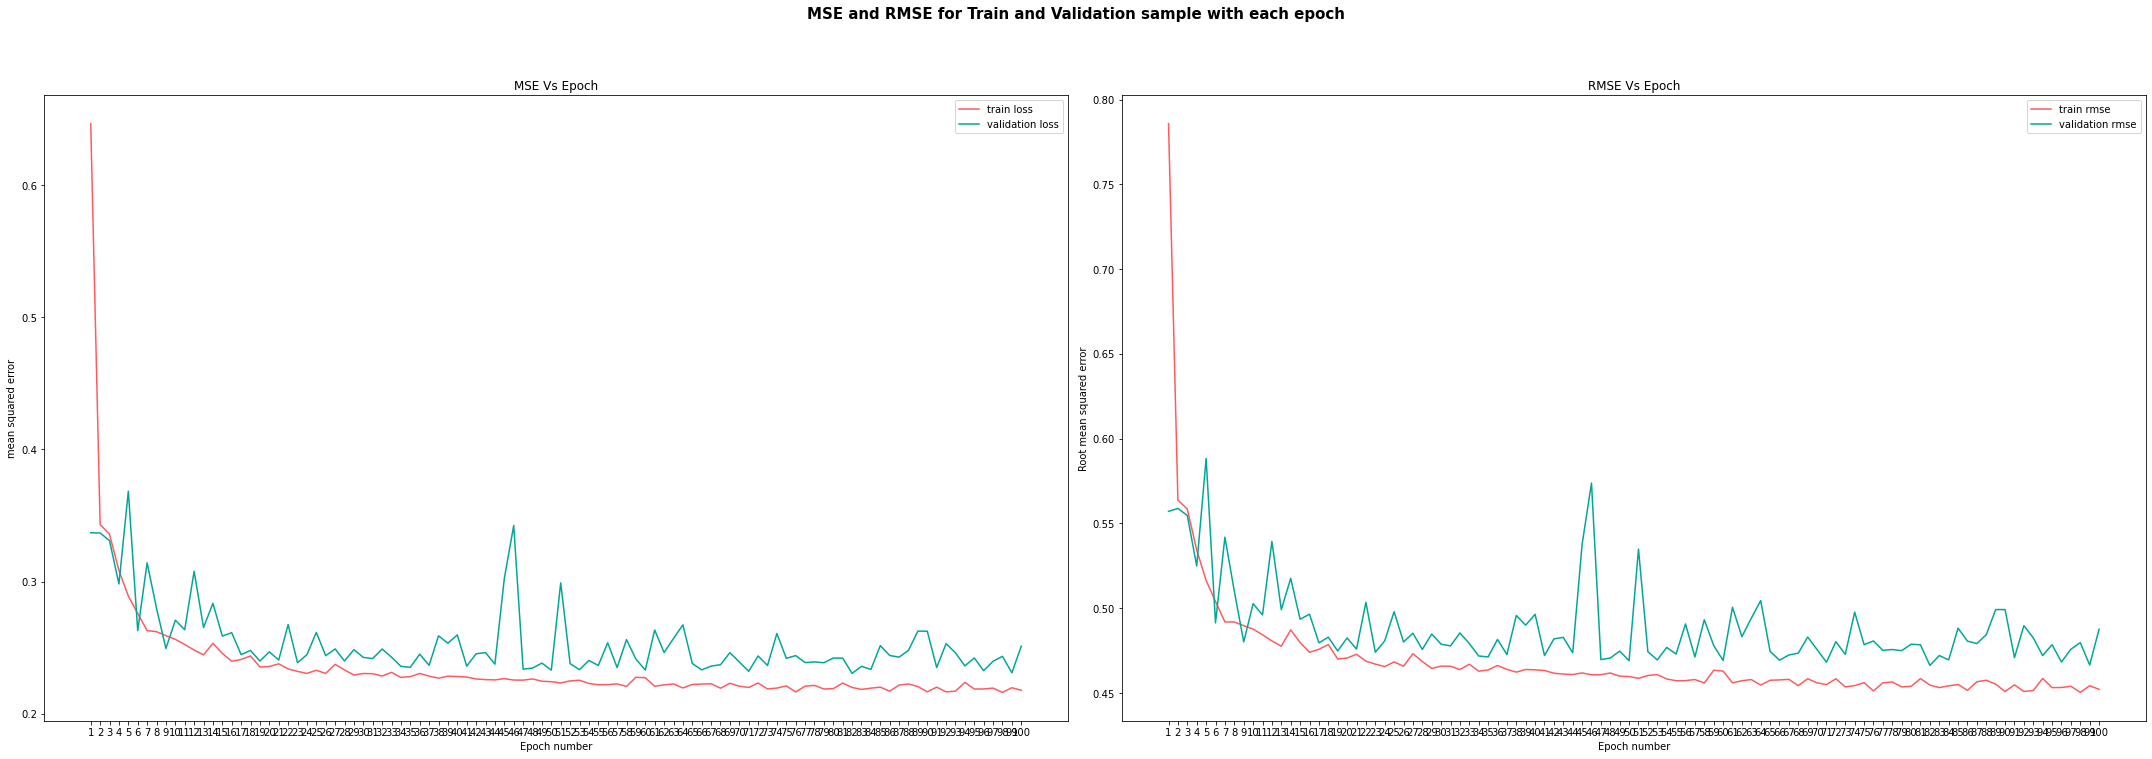

In [122]:
### Plot the graphs
fig, ax = plt.subplots(1,2, figsize = (30,10))
ax[0].plot(df['epochs'], df['loss'], color = '#FF5A5F')
ax[0].plot(df['epochs'], df['val_loss'], color = '#00A699')
ax[0].legend(['train loss', 'validation loss'])
ax[0].set(xlabel="Epoch number", ylabel="mean squared error")
ax[0].set_title('MSE Vs Epoch')

ax[1].plot(df['epochs'],df['root_mean_squared_error'],color = '#FF5A5F')
ax[1].plot(df['epochs'], df['val_root_mean_squared_error'],color = '#00A699')
ax[1].legend(['train rmse', 'validation rmse'])
ax[1].set(xlabel="Epoch number", ylabel="Root mean squared error")
ax[1].set_title('RMSE Vs Epoch')

fig.suptitle('MSE and RMSE for Train and Validation sample with each epoch', fontsize = 15, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.show()